In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])


train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 170M/170M [05:19<00:00, 534kB/s]  


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),  # Regularization
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        
        self.decoder_input = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  
        )

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std 

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterization(mu, logvar)
        x = self.decoder_input(z).view(x.size(0), 128, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar


In [5]:
def vae_loss_function(recon_x, x, mu, logvar, beta=0.1):
    reconstruction_loss = F.mse_loss(recon_x, x, reduction="sum")  
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + beta * kl_divergence


In [6]:
vae = VAE(latent_dim=256).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-4)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  


In [7]:
num_epochs = 300

for epoch in range(num_epochs):
    total_loss = 0
    vae.train()
    
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs, mu, logvar = vae(images)
        loss = vae_loss_function(outputs, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/300], Loss: 41056.5003
Epoch [2/300], Loss: 23134.0243
Epoch [3/300], Loss: 20244.6839
Epoch [4/300], Loss: 18828.0475
Epoch [5/300], Loss: 17890.2783
Epoch [6/300], Loss: 17168.6471
Epoch [7/300], Loss: 16745.5004
Epoch [8/300], Loss: 16362.5803
Epoch [9/300], Loss: 16143.9096
Epoch [10/300], Loss: 15819.3558
Epoch [11/300], Loss: 15259.4053
Epoch [12/300], Loss: 15099.6694
Epoch [13/300], Loss: 14974.3914
Epoch [14/300], Loss: 14907.9837
Epoch [15/300], Loss: 14793.5950
Epoch [16/300], Loss: 14758.9677
Epoch [17/300], Loss: 14685.9862
Epoch [18/300], Loss: 14569.0417
Epoch [19/300], Loss: 14529.2722
Epoch [20/300], Loss: 14477.0306
Epoch [21/300], Loss: 14203.9459
Epoch [22/300], Loss: 14155.6405
Epoch [23/300], Loss: 14109.9339
Epoch [24/300], Loss: 14117.1192
Epoch [25/300], Loss: 14064.4828
Epoch [26/300], Loss: 14033.7029
Epoch [27/300], Loss: 13989.5016
Epoch [28/300], Loss: 13971.8817
Epoch [29/300], Loss: 13972.6813
Epoch [30/300], Loss: 13934.4682
Epoch [31/300], Los

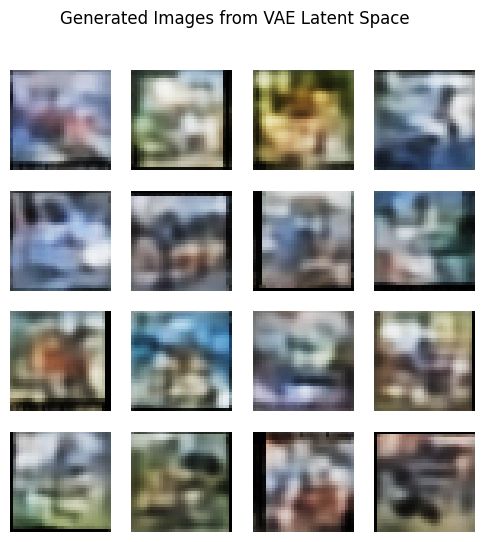

In [8]:
vae.eval()
with torch.no_grad():
    z = torch.randn(16, 256).to(device)  
    generated_images = vae.decoder(vae.decoder_input(z).view(16, 128, 4, 4)).cpu()

# Plot generated images
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  
    ax.axis("off")

plt.suptitle("Generated Images from VAE Latent Space")
plt.show()


In [17]:
torch.save(vae.state_dict(), "vae_cifar10.pth")
print("✅ VAE model saved!")


✅ VAE model saved!


In [9]:

test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)


vae.eval()
with torch.no_grad():
    reconstructed_images, _, _ = vae(test_images)

loss = F.mse_loss(reconstructed_images, test_images).item()
print(f"🔹 VAE Reconstruction Loss: {loss:.4f}")


🔹 VAE Reconstruction Loss: 0.0207


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader


class Autoencoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, latent_dim)
        )

        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


ae_model = Autoencoder(latent_dim=100).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)


num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = ae_model(images)
        loss = criterion(outputs, images)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], AE Loss: {total_loss / len(train_loader):.4f}")


torch.save(ae_model.state_dict(), "autoencoder_cifar10.pth")
print("✅ Autoencoder training completed!")


Files already downloaded and verified
Epoch [1/50], AE Loss: 0.2609
Epoch [2/50], AE Loss: 0.2560
Epoch [3/50], AE Loss: 0.2560
Epoch [4/50], AE Loss: 0.2560
Epoch [5/50], AE Loss: 0.2560
Epoch [6/50], AE Loss: 0.2560
Epoch [7/50], AE Loss: 0.2560
Epoch [8/50], AE Loss: 0.2560
Epoch [9/50], AE Loss: 0.2560
Epoch [10/50], AE Loss: 0.2560
Epoch [11/50], AE Loss: 0.2560
Epoch [12/50], AE Loss: 0.2560
Epoch [13/50], AE Loss: 0.2560
Epoch [14/50], AE Loss: 0.2560
Epoch [15/50], AE Loss: 0.2560
Epoch [16/50], AE Loss: 0.2560
Epoch [17/50], AE Loss: 0.2560
Epoch [18/50], AE Loss: 0.2560
Epoch [19/50], AE Loss: 0.2560
Epoch [20/50], AE Loss: 0.2560
Epoch [21/50], AE Loss: 0.2560
Epoch [22/50], AE Loss: 0.2560
Epoch [23/50], AE Loss: 0.2560
Epoch [24/50], AE Loss: 0.2560
Epoch [25/50], AE Loss: 0.2560
Epoch [26/50], AE Loss: 0.2560
Epoch [27/50], AE Loss: 0.2560
Epoch [28/50], AE Loss: 0.2560
Epoch [29/50], AE Loss: 0.2560
Epoch [30/50], AE Loss: 0.2560
Epoch [31/50], AE Loss: 0.2559
Epoch [32/

In [15]:

torch.save(ae_model.state_dict(), "autoencoder_cifar10.pth")
print("✅ Autoencoder model weights saved successfully!")


✅ Autoencoder model weights saved successfully!


In [16]:

ae_model = Autoencoder(latent_dim=100).to(device)


ae_model.load_state_dict(torch.load("autoencoder_cifar10.pth"))


ae_model.eval()
print("✅ Autoencoder model loaded successfully!")


✅ Autoencoder model loaded successfully!


C:\Users\CSIR_prosthetic\AppData\Local\Temp\ipykernel_16016\3136093701.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load("autoencoder_c

In [19]:
import torch


ae_model.load_state_dict(torch.load("autoencoder_cifar10.pth"))
ae_model.eval()


vae.load_state_dict(torch.load("vae_cifar10.pth"))
vae.eval()

print("✅ Both AE and VAE models loaded successfully!")


✅ Both AE and VAE models loaded successfully!


C:\Users\CSIR_prosthetic\AppData\Local\Temp\ipykernel_16016\1444863018.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load("autoencoder_c

In [20]:
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("✅ Test dataset loaded!")


Files already downloaded and verified
✅ Test dataset loaded!


🔹 Autoencoder Reconstruction Loss: 0.2658
🔹 Variational Autoencoder Reconstruction Loss: 0.2752


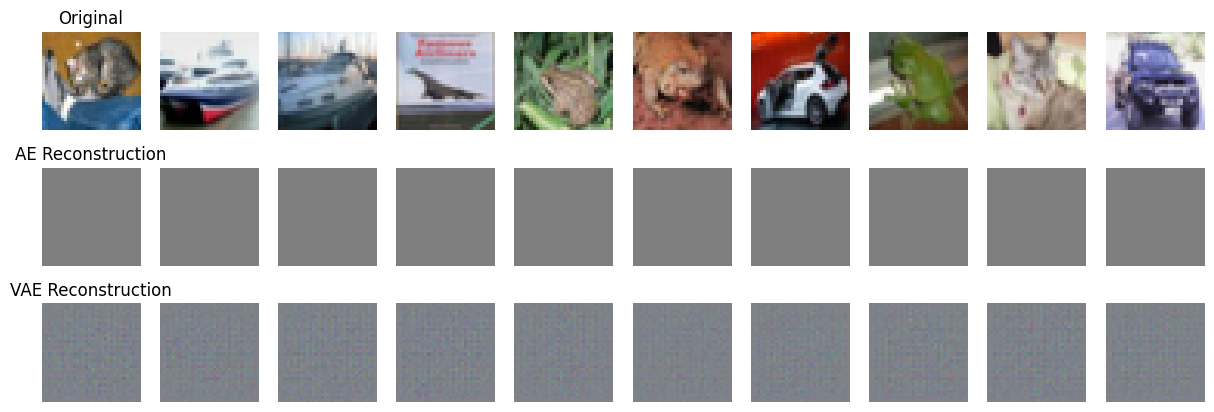

In [22]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Get a batch of test images
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device) 

# Compute reconstructions
with torch.no_grad():
    ae_reconstructed = ae_model(test_images).cpu()  
    vae_reconstructed, _, _ = vae(test_images)  

ae_loss = F.mse_loss(ae_reconstructed.to(device), test_images).item()
vae_loss = F.mse_loss(vae_reconstructed, test_images).item()

print(f"🔹 Autoencoder Reconstruction Loss: {ae_loss:.4f}")
print(f"🔹 Variational Autoencoder Reconstruction Loss: {vae_loss:.4f}")


fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
  
    axes[0, i].imshow(test_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
    axes[0, i].axis("off")

   
    axes[1, i].imshow(ae_reconstructed[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    axes[1, i].axis("off")

   
    axes[2, i].imshow(vae_reconstructed[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    axes[2, i].axis("off")

axes[0, 0].set_title("Original", fontsize=12)
axes[1, 0].set_title("AE Reconstruction", fontsize=12)
axes[2, 0].set_title("VAE Reconstruction", fontsize=12)
plt.show()


VAE Without Regularization

In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 170M/170M [00:18<00:00, 9.33MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt


class VAE_NoReg(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE_NoReg, self).__init__()
        self.latent_dim = latent_dim

        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

       
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        
        self.decoder_input = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  
        )

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterization(mu, logvar)
        x = self.decoder_input(z).view(x.size(0), 128, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


vae_noreg = VAE_NoReg(latent_dim=256).to(device)


optimizer_noreg = optim.Adam(vae_noreg.parameters(), lr=0.001)  


scheduler_noreg = optim.lr_scheduler.StepLR(optimizer_noreg, step_size=10, gamma=0.5)


def vae_loss_function(recon_x, x, mu, logvar, beta=0.1):
    reconstruction_loss = F.mse_loss(recon_x, x, reduction="sum")  # MSE loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + beta * kl_divergence


num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0
    vae_noreg.train()
    
    for images, _ in train_loader:
        images = images.to(device)
        optimizer_noreg.zero_grad()
        outputs, mu, logvar = vae_noreg(images)
        loss = vae_loss_function(outputs, images, mu, logvar)
        loss.backward()
        optimizer_noreg.step()
        total_loss += loss.item()
    
    scheduler_noreg.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


torch.save(vae_noreg.state_dict(), "vae_noreg_cifar10.pth")
print("✅ VAE Without Regularization training completed!")


Files already downloaded and verified
Epoch [1/50], Loss: 31211.1843
Epoch [2/50], Loss: 17457.9144
Epoch [3/50], Loss: 14738.9099
Epoch [4/50], Loss: 13450.2570
Epoch [5/50], Loss: 12701.9288
Epoch [6/50], Loss: 12173.6998
Epoch [7/50], Loss: 11763.4107
Epoch [8/50], Loss: 11497.8540
Epoch [9/50], Loss: 11283.7870
Epoch [10/50], Loss: 11027.9619
Epoch [11/50], Loss: 10573.3972
Epoch [12/50], Loss: 10472.9955
Epoch [13/50], Loss: 10445.9973
Epoch [14/50], Loss: 10357.2275
Epoch [15/50], Loss: 10244.6717
Epoch [16/50], Loss: 10198.1254
Epoch [17/50], Loss: 10146.5468
Epoch [18/50], Loss: 10088.9099
Epoch [19/50], Loss: 10048.2824
Epoch [20/50], Loss: 9970.0887
Epoch [21/50], Loss: 9818.2931
Epoch [22/50], Loss: 9763.9938
Epoch [23/50], Loss: 9753.7868
Epoch [24/50], Loss: 9736.8847
Epoch [25/50], Loss: 9719.2252
Epoch [26/50], Loss: 9690.5807
Epoch [27/50], Loss: 9657.5045
Epoch [28/50], Loss: 9666.0228
Epoch [29/50], Loss: 9629.4477
Epoch [30/50], Loss: 9623.6919
Epoch [31/50], Loss: 9

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define VAE Model with Regularization
class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),  # Regularization
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        # Latent space
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Outputs [-1,1] to match input normalization
        )

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterization(mu, logvar)
        x = self.decoder_input(z).view(x.size(0), 128, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar


In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize VAE
vae = VAE(latent_dim=256).to(device)

# Define optimizer with weight decay (L2 regularization)
optimizer = optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-4)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Define VAE Loss Function
def vae_loss_function(recon_x, x, mu, logvar, beta=0.1):
    reconstruction_loss = F.mse_loss(recon_x, x, reduction="sum")  # MSE loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + beta * kl_divergence


In [11]:
num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0
    vae.train()
    
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs, mu, logvar = vae(images)
        loss = vae_loss_function(outputs, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

torch.save(vae.state_dict(), "vae_cifar10.pth")
print("✅ VAE with Regularization training completed & saved!")


Epoch [1/50], Loss: 36622.1502
Epoch [2/50], Loss: 22355.5351
Epoch [3/50], Loss: 19684.5893
Epoch [4/50], Loss: 18240.7286
Epoch [5/50], Loss: 17484.1456
Epoch [6/50], Loss: 16873.3327
Epoch [7/50], Loss: 16453.1217
Epoch [8/50], Loss: 16107.1204
Epoch [9/50], Loss: 15873.8878
Epoch [10/50], Loss: 15616.4633
Epoch [11/50], Loss: 15129.2866
Epoch [12/50], Loss: 15004.5605
Epoch [13/50], Loss: 14946.0318
Epoch [14/50], Loss: 14873.9146
Epoch [15/50], Loss: 14793.3773
Epoch [16/50], Loss: 14714.7136
Epoch [17/50], Loss: 14673.6771
Epoch [18/50], Loss: 14634.6020
Epoch [19/50], Loss: 14562.6632
Epoch [20/50], Loss: 14548.8211
Epoch [21/50], Loss: 14280.1390
Epoch [22/50], Loss: 14253.6773
Epoch [23/50], Loss: 14219.1534
Epoch [24/50], Loss: 14209.1928
Epoch [25/50], Loss: 14160.7959
Epoch [26/50], Loss: 14159.2915
Epoch [27/50], Loss: 14147.2288
Epoch [28/50], Loss: 14106.4327
Epoch [29/50], Loss: 14080.5106
Epoch [30/50], Loss: 14090.6420
Epoch [31/50], Loss: 13965.3719
Epoch [32/50], Lo

In [12]:
import torch

# Load VAE with Regularization
vae_with_reg = VAE(latent_dim=256).to(device)
vae_with_reg.load_state_dict(torch.load("vae_cifar10.pth"))
vae_with_reg.eval()

# Load VAE without Regularization
vae_noreg = VAE_NoReg(latent_dim=256).to(device)
vae_noreg.load_state_dict(torch.load("vae_noreg_cifar10.pth"))
vae_noreg.eval()

print("✅ Both VAE models (with and without regularization) loaded successfully!")


✅ Both VAE models (with and without regularization) loaded successfully!


C:\Users\CSIR_prosthetic\AppData\Local\Temp\ipykernel_21772\2812163446.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_with_reg.load_state_dict(torch.load("vae_cifar

In [14]:
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("✅ Test dataset loaded!")


Files already downloaded and verified
✅ Test dataset loaded!


In [15]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Get a batch of test images
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# Compute reconstructions
with torch.no_grad():
    vae_reg_reconstructed, _, _ = vae_with_reg(test_images)
    vae_noreg_reconstructed, _, _ = vae_noreg(test_images)

# Compute MSE Loss for both models
vae_reg_loss = F.mse_loss(vae_reg_reconstructed, test_images).item()
vae_noreg_loss = F.mse_loss(vae_noreg_reconstructed, test_images).item()

print(f"🔹 VAE with Regularization Loss: {vae_reg_loss:.4f}")
print(f"🔹 VAE without Regularization Loss: {vae_noreg_loss:.4f}")


🔹 VAE with Regularization Loss: 0.0220
🔹 VAE without Regularization Loss: 0.0150


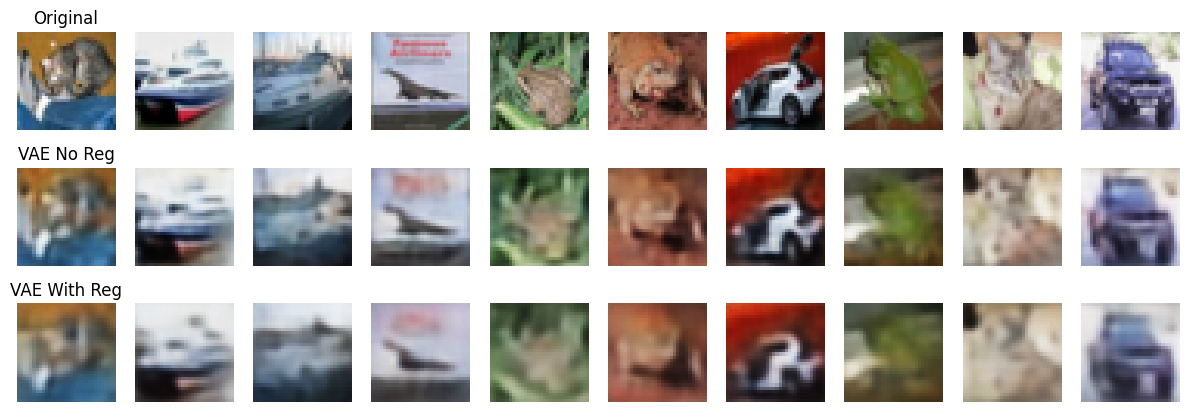

In [16]:
# Plot Original vs. Reconstructed Images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
    # Original images
    axes[0, i].imshow(test_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
    axes[0, i].axis("off")

    # VAE without Regularization
    axes[1, i].imshow(vae_noreg_reconstructed[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
    axes[1, i].axis("off")

    # VAE with Regularization
    axes[2, i].imshow(vae_reg_reconstructed[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
    axes[2, i].axis("off")

axes[0, 0].set_title("Original")
axes[1, 0].set_title("VAE No Reg")
axes[2, 0].set_title("VAE With Reg")
plt.show()
